# Total mass constraints
Here, we will consider the unbalanced optimal transport under the constraint
$\begin{align}\rho_t(\Omega) = F(t) \end{align}$ 
where $F(t)$ is a prescribed function.

In [9]:
# Import relevant libraries

import math
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact

import matplotlib.animation as animation

In [10]:
from pathlib import Path
def save_solution_1D(z, filename):
    p = Path(filename)
    if p.suffix != ".npz":
        p = p.with_suffix(".npz")
    p.parent.mkdir(parents=True, exist_ok=True)   # <-- ensure folder exists
    np.savez(p, U_D0=z.U.D[0], U_D1=z.U.D[1], U_Z=z.U.Z,
                V_D0=z.V.D[0], V_D1=z.V.D[1], V_Z=z.V.Z)
    print(f"Solution saved to {p}")

def save_solution_2D(z, filename):
    p = Path(filename)
    if p.suffix != ".npz":
        p = p.with_suffix(".npz")
    p.parent.mkdir(parents=True, exist_ok=True)   # <-- ensure folder exists
    np.savez(p, U_D0=z.U.D[0], U_D1=z.U.D[1], U_D2=z.U.D[2], U_Z=z.U.Z,
                V_D0=z.V.D[0], V_D1=z.V.D[1], V_D2=z.V.D[2], V_Z=z.V.Z)
    print(f"Solution saved to {p}")

# Figure 1(a): Comaprison with Spherical-Hellinger Kantrovich
The case $F(t) = 1$ is called the spherical Hellinger-Kantrovich distance.

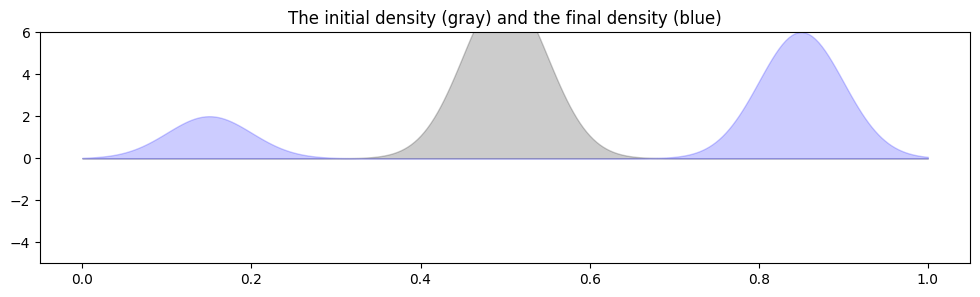

Solution saved to test_cases\SHK_1D_solution.npz
L2 distance between reparametrized distribution and constrained distribution: 0.1438354942364191


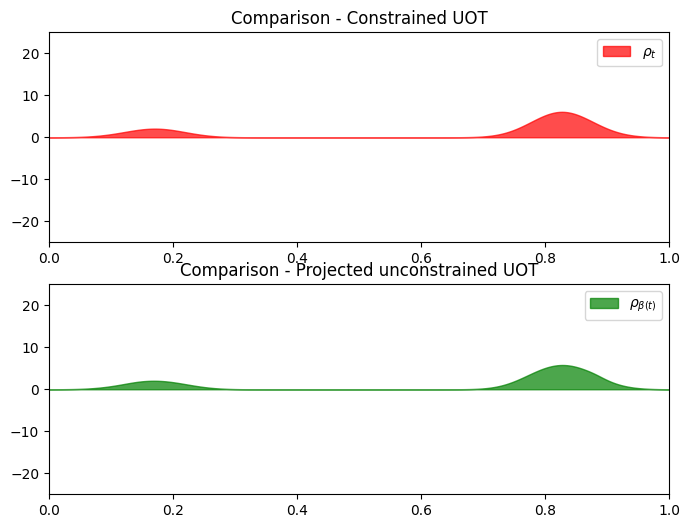

In [12]:
# Import relevant libraries

import math
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation
np.random.seed(58)   

def WFR_to_SHK(WFR):
    """ Convert WFR to SHK
    WFR: float, WFR value
    return: float, SHK value"""
    return math.acos(1-WFR**2/4)

def beta(t, SHK, r0, r1):
    """
    Computes the value of β(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of β(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * np.sin(t * SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in beta(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

def r(t, SHK, r0, r1):
    """
    Computes the value of r(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of r(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * r1 * np.sin(SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in r(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

def reparametrize_mass_distributions(mass_distributions, SHK, r0, r1, cs, ll):
    """
    Reparametrize the mass distributions according to the beta(t) function.

    Parameters:
    - mass_distributions (np.ndarray): Array of shape (time_dim, *space_dims)
    - SHK (float): SHK parameter for beta(t)
    - r0 (float): r0 parameter for beta(t)
    - r1 (float): r1 parameter for beta(t)
    - cs (tuple): the size of the spatial grid
    - ll (tuple): the length of the spatial domain

    Returns:
    - np.ndarray: Reparametrized mass distributions of the same shape.
    """
    time_dim = mass_distributions.shape[0]
    T = time_dim - 1

    # Original time grid
    t = np.linspace(0, 1, time_dim)  # t_i = i / T

    # Compute beta(t_i)
    beta_t = beta(t, SHK, r0, r1)

    # Ensure beta_t is within [0, 1]
    beta_t = np.clip(beta_t, 0, 1)

    # Scale beta_t to index space and find lower indices
    beta_scaled = beta_t * T
    k = np.floor(beta_scaled).astype(int)
    k = np.clip(k, 0, T - 1)  # Ensure indices are within valid range

    # Calculate weights for linear interpolation
    t_k = k / T
    t_k1 = (k + 1) / T
    delta_t = t_k1 - t_k
    delta_t[delta_t == 0] = 1e-10  # Avoid division by zero

    w_k1 = (beta_t - t_k) / delta_t
    w_k = 1 - w_k1

    # Reshape weights for broadcasting
    weight_shape = (time_dim,) + (1,) * (mass_distributions.ndim - 1)
    w_k = w_k.reshape(weight_shape)
    w_k1 = w_k1.reshape(weight_shape)

    # Interpolate mass distributions
    mass_k = mass_distributions[k]
    mass_k1 = mass_distributions[k + 1]

    mass_beta_t = w_k * mass_k + w_k1 * mass_k1
    
    # Normalize for each time step
    reshape = (time_dim,) + (1,) * (mass_beta_t.ndim-1)
    mass_beta_t = (mass_beta_t / np.sum(mass_beta_t, axis=tuple(range(1, mass_beta_t.ndim))).reshape(reshape)) * np.prod(cs[1:]) / np.prod(ll[1:])

    return mass_beta_t

# Define the initial and the terminal distributions
K = 256

# Generate the initial and terminal distributions
X = np.linspace(0, 1, K)  # Discretization of the time-space domain
rho_0 = np.exp(-0.5 * (X-0.5) ** 2 / (0.05 ** 2)) #generate_gaussian_mixture(1, 1.0, K, sigma=0.02, dimension=1)
rho_1 = 0.25 * np.exp(-0.5 * (X-0.15) ** 2 / (0.05 ** 2)) + 0.75 * np.exp(-0.5 * (X-0.85) ** 2 / (0.05 ** 2))
rho_0 /= (np.sum(rho_0) / 256)  # Normalize to make it a density. Our algorithm assumes everything is a density.
rho_1 /= (np.sum(rho_1) / 256)  # Normalize to make it a density. Our algorithm assumes everything is a density.


plt.figure(figsize=(12, 3))
plt.ylim(-5, 6)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2) 
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

T = 15
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0), niter = 1000, big_matrix=True)

WFR = np.sqrt(z.V.energy(1.0, 2.0, 2.0))
SHK = WFR_to_SHK(WFR)
r0 = 1.0
r1 = 1.0

# Reparametrize the mass distributions
reparam_D = reparametrize_mass_distributions(z.U.D[0], SHK, r0, r1, (1, K), (1, 1))

# Calculate the constrained geodesic
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0), np.ones((T, K)), np.ones(T), big_matrix=True, niter = 10000)

# save the solution for further testing
save_solution_1D(z, "test_cases/SHK_1D_solution")

# -------------------------------------------------------------
# CAMERA‑READY OVERLAY
#   – always plot t = 0 (gray) and t = 1 (blue)
#   – constrained uOT snapshot filled in RED
#   – projected curve dotted green
#   – snapshots at t = 0.25, 0.50, 0.75
# -------------------------------------------------------------
import os
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": False})

os.makedirs("figures", exist_ok=True)          # ensure output dir exists
t_fracs = [0.25, 0.50, 0.75]                   # snapshot times (fractions)

for t_frac in t_fracs:
    idx = int(round(t_frac * T))               # convert fraction → index
    idx = max(0, min(idx, T - 1))              # clamp to valid range

    # y‑range that hugs *all* densities shown
    ymax = max(z.U.D[0][[0, idx, T - 1], :].max(),
               reparam_D[idx, :].max()) * 1.05

    fig, ax = plt.subplots(figsize=(3.5, 0.7))   # ≈ 1‑column figure

    # 0️⃣ initial density  (gray fill)
    ax.fill_between(X, z.U.D[0][0, :],
                    color="k", alpha=0.20)

    # 1️⃣ final density    (blue fill)
    ax.fill_between(X, z.U.D[0][T - 1, :],
                    color="blue", alpha=0.20)

    # 2️⃣ constrained uOT at snapshot (red fill)
    ax.fill_between(X, z.U.D[0][idx, :],
                    color="red", alpha=0.25)

    # 3️⃣ projected uOT    (green dotted line)
    ax.plot(X, reparam_D[idx, :],
            linestyle=":", linewidth=1.4, color="green")

    # cosmetic clean‑up
    ax.set_xlim(0, 1)
    ax.set_ylim(0, ymax)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"], fontsize=10)
    ax.set_yticks([])

    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    fig.tight_layout(pad=0.05)
    fig.savefig(f"figures/SHK_1D_paper_t{t_frac:.2f}.png",
                dpi=600, bbox_inches="tight", transparent=True)
    plt.close(fig)


# -------------------------------------------------------------
# Plotting the video
# -------------------------------------------------------------

# Set up the figure and axes
ylim = [-25, 25]
fig, axs = plt.subplots(2, 1, figsize=[8, 6])

def init():
    # Initialize the plots
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    return axs

def update(t):
    for ax in axs:
        ax.clear()

    # First subplot for x.U.D
    axs[0].fill_between(X, z.U.D[0][t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    axs[0].set_title('Comparison - Constrained UOT')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[0].legend()

    # Second subplot for reparam_D
    axs[1].fill_between(X, reparam_D[t, :], color="g", alpha=0.7, label=r'$\rho_{\beta(t)}$')
    axs[1].set_title('Comparison - Projected unconstrained UOT')
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    axs[1].legend()

    return axs

ani = animation.FuncAnimation(fig, update, frames=range(T), init_func=init, blit=False)

# Save the animation as an MP4 video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
ani.save('videos/SHK_1D.mp4', writer=writer)

# Calculate the L2 distance between the reparametrized distribution and the constrained distribution
l2_distance = np.linalg.norm(reparam_D - z.U.D[0], ord=2) * np.sqrt(1 / (K * T)) 
print(f"L2 distance between reparametrized distribution and constrained distribution: {l2_distance}")

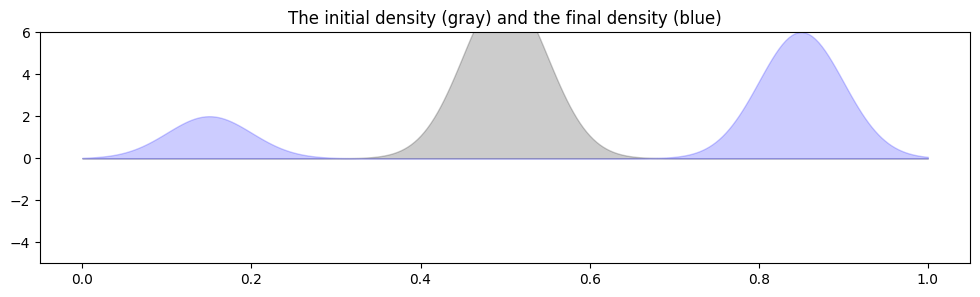

L2 distance between reparametrized distribution and constrained distribution: 0.12736970114155688


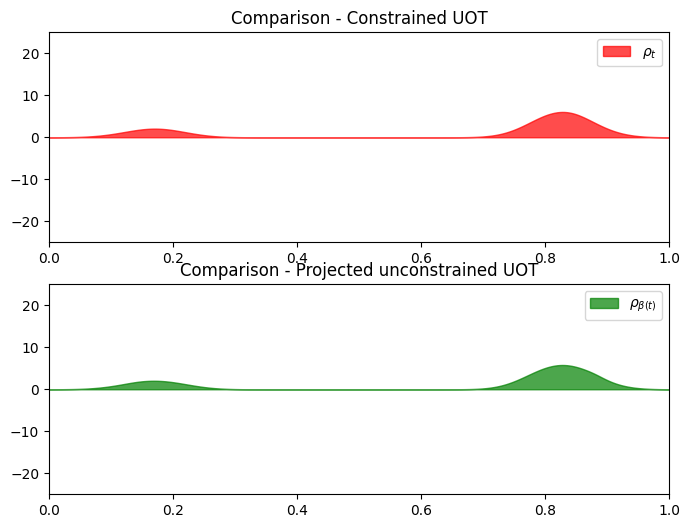

In [13]:
# Import relevant libraries

import math
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation
np.random.seed(58)   

def WFR_to_SHK(WFR):
    """ Convert WFR to SHK
    WFR: float, WFR value
    return: float, SHK value"""
    return math.acos(1-WFR**2/4)

def beta(t, SHK, r0, r1):
    """
    Computes the value of β(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of β(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * np.sin(t * SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in beta(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

def r(t, SHK, r0, r1):
    """
    Computes the value of r(t) based on the formula.

    Parameters:
    - t (float or np.ndarray): Parameter(s) between 0 and 1.
    - SHK (float): The SHK value.
    - r0 (float): Radius parameter r0.
    - r1 (float): Radius parameter r1.

    Returns:
    - float or np.ndarray: The computed value(s) of r(t).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    numerator = r0 * r1 * np.sin(SHK)
    denominator = r1 * np.sin((1 - t) * SHK) + r0 * np.sin(t * SHK)
    
    # Check for zero denominators
    if np.any(denominator == 0):
        raise ValueError("Denominator in r(t) calculation is zero for at least one element in t.")
    
    return numerator / denominator

def reparametrize_mass_distributions(mass_distributions, SHK, r0, r1, cs, ll):
    """
    Reparametrize the mass distributions according to the beta(t) function.

    Parameters:
    - mass_distributions (np.ndarray): Array of shape (time_dim, *space_dims)
    - SHK (float): SHK parameter for beta(t)
    - r0 (float): r0 parameter for beta(t)
    - r1 (float): r1 parameter for beta(t)
    - cs (tuple): the size of the spatial grid
    - ll (tuple): the length of the spatial domain

    Returns:
    - np.ndarray: Reparametrized mass distributions of the same shape.
    """
    time_dim = mass_distributions.shape[0]
    T = time_dim - 1

    # Original time grid
    t = np.linspace(0, 1, time_dim)  # t_i = i / T

    # Compute beta(t_i)
    beta_t = beta(t, SHK, r0, r1)

    # Ensure beta_t is within [0, 1]
    beta_t = np.clip(beta_t, 0, 1)

    # Scale beta_t to index space and find lower indices
    beta_scaled = beta_t * T
    k = np.floor(beta_scaled).astype(int)
    k = np.clip(k, 0, T - 1)  # Ensure indices are within valid range

    # Calculate weights for linear interpolation
    t_k = k / T
    t_k1 = (k + 1) / T
    delta_t = t_k1 - t_k
    delta_t[delta_t == 0] = 1e-10  # Avoid division by zero

    w_k1 = (beta_t - t_k) / delta_t
    w_k = 1 - w_k1

    # Reshape weights for broadcasting
    weight_shape = (time_dim,) + (1,) * (mass_distributions.ndim - 1)
    w_k = w_k.reshape(weight_shape)
    w_k1 = w_k1.reshape(weight_shape)

    # Interpolate mass distributions
    mass_k = mass_distributions[k]
    mass_k1 = mass_distributions[k + 1]

    mass_beta_t = w_k * mass_k + w_k1 * mass_k1
    
    # Normalize for each time step
    reshape = (time_dim,) + (1,) * (mass_beta_t.ndim-1)
    mass_beta_t = (mass_beta_t / np.sum(mass_beta_t, axis=tuple(range(1, mass_beta_t.ndim))).reshape(reshape)) * np.prod(cs[1:]) / np.prod(ll[1:])

    return mass_beta_t

# Define the initial and the terminal distributions
K = 256

# Generate the initial and terminal distributions
X = np.linspace(0, 1, K)  # Discretization of the time-space domain
rho_0 = np.exp(-0.5 * (X-0.5) ** 2 / (0.05 ** 2)) #generate_gaussian_mixture(1, 1.0, K, sigma=0.02, dimension=1)
rho_1 = 0.25 * np.exp(-0.5 * (X-0.15) ** 2 / (0.05 ** 2)) + 0.75 * np.exp(-0.5 * (X-0.85) ** 2 / (0.05 ** 2))
rho_0 /= (np.sum(rho_0) / 256)  # Normalize to make it a density. Our algorithm assumes everything is a density.
rho_1 /= (np.sum(rho_1) / 256)  # Normalize to make it a density. Our algorithm assumes everything is a density.


plt.figure(figsize=(12, 3))
plt.ylim(-5, 6)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2) 
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

T = 15
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0), niter = 1000, big_matrix=True)

WFR = np.sqrt(z.V.energy(1.0, 2.0, 2.0))
SHK = WFR_to_SHK(WFR)
r0 = 1.0
r1 = 1.0

# Reparametrize the mass distributions
reparam_D = reparametrize_mass_distributions(z.U.D[0], SHK, r0, r1, (1, K), (1, 1))

Hs = [np.ones((T, K)), np.zeros((T, K)), np.zeros((T, K))]
GL = np.ones(T)
GU = np.ones(T)
z, lists = computeGeodesic_inequality(
    rho_0, rho_1, T, (1.0, 1.0), Hs=Hs, GL=GL, GU=GU, niter=10000
)

# save the solution for further testing
#save_solution_1D(z, "test_cases/SHK_1D_solution")

# -------------------------------------------------------------
# CAMERA‑READY OVERLAY
#   – always plot t = 0 (gray) and t = 1 (blue)
#   – constrained uOT snapshot filled in RED
#   – projected curve dotted green
#   – snapshots at t = 0.25, 0.50, 0.75
# -------------------------------------------------------------
import os
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": False})

os.makedirs("figures", exist_ok=True)          # ensure output dir exists
t_fracs = [0.25, 0.50, 0.75]                   # snapshot times (fractions)

for t_frac in t_fracs:
    idx = int(round(t_frac * T))               # convert fraction → index
    idx = max(0, min(idx, T - 1))              # clamp to valid range

    # y‑range that hugs *all* densities shown
    ymax = max(z.U.D[0][[0, idx, T - 1], :].max(),
               reparam_D[idx, :].max()) * 1.05

    fig, ax = plt.subplots(figsize=(3.5, 0.7))   # ≈ 1‑column figure

    # 0️⃣ initial density  (gray fill)
    ax.fill_between(X, z.U.D[0][0, :],
                    color="k", alpha=0.20)

    # 1️⃣ final density    (blue fill)
    ax.fill_between(X, z.U.D[0][T - 1, :],
                    color="blue", alpha=0.20)

    # 2️⃣ constrained uOT at snapshot (red fill)
    ax.fill_between(X, z.U.D[0][idx, :],
                    color="red", alpha=0.25)

    # 3️⃣ projected uOT    (green dotted line)
    ax.plot(X, reparam_D[idx, :],
            linestyle=":", linewidth=1.4, color="green")

    # cosmetic clean‑up
    ax.set_xlim(0, 1)
    ax.set_ylim(0, ymax)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"], fontsize=10)
    ax.set_yticks([])

    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    fig.tight_layout(pad=0.05)
    fig.savefig(f"figures/SHK_1D_paper_t{t_frac:.2f}.png",
                dpi=600, bbox_inches="tight", transparent=True)
    plt.close(fig)


# -------------------------------------------------------------
# Plotting the video
# -------------------------------------------------------------

# Set up the figure and axes
ylim = [-25, 25]
fig, axs = plt.subplots(2, 1, figsize=[8, 6])

def init():
    # Initialize the plots
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    return axs

def update(t):
    for ax in axs:
        ax.clear()

    # First subplot for x.U.D
    axs[0].fill_between(X, z.U.D[0][t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    axs[0].set_title('Comparison - Constrained UOT')
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(ylim)
    axs[0].legend()

    # Second subplot for reparam_D
    axs[1].fill_between(X, reparam_D[t, :], color="g", alpha=0.7, label=r'$\rho_{\beta(t)}$')
    axs[1].set_title('Comparison - Projected unconstrained UOT')
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(ylim)
    axs[1].legend()

    return axs

ani = animation.FuncAnimation(fig, update, frames=range(T), init_func=init, blit=False)

# Save the animation as an MP4 video
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
ani.save('videos/SHK_1D_ineq.mp4', writer=writer)

# Calculate the L2 distance between the reparametrized distribution and the constrained distribution
l2_distance = np.linalg.norm(reparam_D - z.U.D[0], ord=2) * np.sqrt(1 / (K * T)) 
print(f"L2 distance between reparametrized distribution and constrained distribution: {l2_distance}")

# Figure 1(b), (c): Inequality constraint vs unconstrained

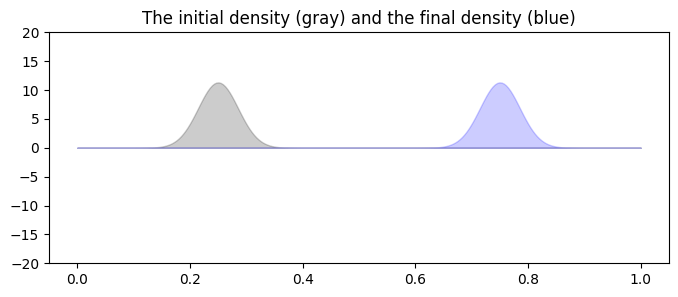

Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.


In [34]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact

# Plotting initial and the final density
sigma = 0.05
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / 256

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 20)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.ones((T,K))
time = np.array([(i+0.5)/T for i in range(0,T)])

xs = []

# Wasserstein
#x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=0.0, #delta=0.5/np.pi, niter=3000)
#xs.append(x)

delta = 0.5 / np.pi
# Wasserstein-Fisher-Rao
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000)
xs.append(x)

# Greater than 1
Hs = [H, np.zeros((T, K)), np.zeros((T, K))]
GL = np.ones((T,))
GU = np.inf * np.ones((T,))
x, lists = computeGeodesic_inequality(rho_0, rho_1, T, ll, H=None, F=None, Hs=Hs, GL=GL, GU=GU, p= 2.0, q=2.0, delta=delta, niter=3000, big_matrix=True, verbose=True)
xs.append(x)

# Greater than 0.8
Hs = [H, np.zeros((T, K)), np.zeros((T, K))]
GL = 0.8 * np.ones((T,))
GU = np.inf * np.ones((T,))
x, lists = computeGeodesic_inequality(rho_0, rho_1, T, ll, H=None, F=None, Hs=Hs, GL=GL, GU=GU, p= 2.0, q=2.0, delta=delta, niter=3000, big_matrix=True, verbose=True)
xs.append(x)


In [35]:
# --------------------------------------------------------------
#  Plot with tall inset that keeps white background even when
#  savefig(..., transparent=True) is used.                      |
# --------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# ---------- bookkeeping ---------------------------------------
T        = xs[0].U.D[0].shape[0]
t0, th   = 0, T // 2
t1       = T - 1
X        = np.linspace(0, 1, xs[0].U.D[0].shape[1])
solutions = xs

half_cols = ["darkorange", "forestgreen", "purple"]
labels    = [r"WFR $(t=\tfrac12)$",
             r"$\rho \ge 1\;(t=\tfrac12)$",
             r"$\rho \ge 0.8\;(t=\tfrac12)$"]

ymax = max(sol.U.D[0][[t0, th, t1]].max() for sol in solutions) * 1.05

plt.rcParams.update({"font.size": 10, "text.usetex": False})

fig, ax = plt.subplots(figsize=(3.5, 0.625), facecolor="white")

# ---------- t = 0 (gray) & t = 1 (blue) ------------------------
ax.fill_between(X, solutions[0].U.D[0][t0], 0,
                color="0.6", alpha=0.35, label=r"$t=0$")
ax.fill_between(X, solutions[0].U.D[0][t1], 0,
                color="royalblue", alpha=0.35, label=r"$t=1$")

# ---------- t = ½ : three dotted lines -------------------------
for sol, col, lab in zip(solutions, half_cols, labels):
    ax.plot(X, sol.U.D[0][th], lw=1.4, color=col, label=lab)

# ---------- tidy main axis -------------------------------------
ax.set_xlim(0, 1);          ax.set_ylim(0, ymax)
ax.set_xticks([0, .5, 1]);  ax.set_xticklabels(["0", "0.5", "1"])
ax.set_yticks([])
for side in ("left", "right", "top"):
    ax.spines[side].set_visible(False)

# --------------------------------------------------------------
#  INSET : tall + solid‑white background via extra Rectangle    |
# --------------------------------------------------------------
axins = inset_axes(
    ax,
    width="40%", height="130%",           # 140 % of parent height
    bbox_to_anchor=(0.27, -0.40, 0.22, 1.40),  # x0, y0, w, h in Axes coords
    bbox_transform=ax.transAxes,
    loc="upper center",
    borderpad=0,
)

# --- white rectangle that survives transparent=True -----------
axins.add_patch(
    Rectangle((0, 0), 1, 1,
              transform=axins.transAxes,
              facecolor="0.92",
              edgecolor="none",
              zorder=-10)
)

# half‑time lines (draw baseline last so it sits on top)
for sol, col in zip(reversed(solutions), reversed(half_cols)):
    axins.plot(X, sol.U.D[0][th], color=col, lw=0.7)

axins.set_xlim(0.20, 0.30)
axins.set_ylim(0, ymax * 0.3)
axins.set_xticks([]);  axins.set_yticks([])

# transparent rectangle linking inset ↔ main panel
mark_inset(ax, axins, loc1=2, loc2=3,
           fc="none", ec="0.7", lw=0.5)

# --------------------------------------------------------------
fig.tight_layout(pad=0.05)
fig.savefig("figures/inequality_1D_camera_ready.png",
            dpi=600, bbox_inches="tight", transparent=True)
plt.close(fig)
print("✓ Saved figures/inequality_1D_camera_ready.png")


✓ Saved figures/inequality_1D_camera_ready.png


C:\Users\mao17\AppData\Local\Temp\ipykernel_43732\2314562934.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.05)


In [36]:
# --------------------------------------------------------------
#  Exact‑pixel “total mass vs t” figure: 2211 px × 408 px       |
# --------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -------- data -------------------------------------------------
Ds          = [x.U.D[0] for x in xs]                # three solutions
mass_curves = [np.sum(D, axis=1) / 256 for D in Ds] # total mass vs t
t           = np.linspace(0, 1, Ds[0].shape[0])     # 16 points


# -------- figure geometry for 2211 × 408 px at 600 dpi --------
dpi_out          = 600
fig_width_inch   = 2211 / dpi_out -0.09           # ≈ 3.685"
fig_height_inch  =  528 / dpi_out -0.124          # ≈ 0.680"

rcParams.update({"font.size": 10, "text.usetex": False})
colours = ["darkorange", "forestgreen", "purple"]

fig = plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=dpi_out,
                 facecolor="white")
ax  = fig.add_axes([0.03, 0.04, 0.94, 0.93])  # fill almost everything

# -------- plot -------------------------------------------------
for m, c in zip(mass_curves, colours):
    ax.plot(t, m, marker='o', ms=2, lw=0.9, color=c)

ax.axhline(1.0, color="0.4", lw=0.6, ls="--", zorder=0)
ax.axhline(0.8, color="0.4", lw=0.6, ls=":",  zorder=0)

# -------- axes cosmetics --------------------------------------
ax.set_xlim(0, 1);  ax.set_ylim(0.5, 1.05)
ax.set_xticks([0, 0.5, 1]); ax.set_xticklabels(["0", "0.5", "1"])
ax.set_yticks([0.8, 1.0]);  ax.set_yticklabels(["0.8", "1.0"])
ax.tick_params(axis="both", direction="out", length=2, pad=1)
for s in ("right", "top"): ax.spines[s].set_visible(False)

# -------- tiny “t” label just left of the x‑axis origin -------
ax.text(-0.03, -0.08, r"$t$", transform=ax.transAxes,
        ha="right", va="top", fontsize=9)


# -------- save -----------------------------------------------
fig.savefig("figures/total_mass_camera_ready.png",
            dpi=dpi_out, bbox_inches="tight", pad_inches=0, transparent=True)
plt.close(fig)
print("✓ Saved figures/total_mass_camera_ready.png (2211 × 408 px)")


✓ Saved figures/total_mass_camera_ready.png (2211 × 408 px)


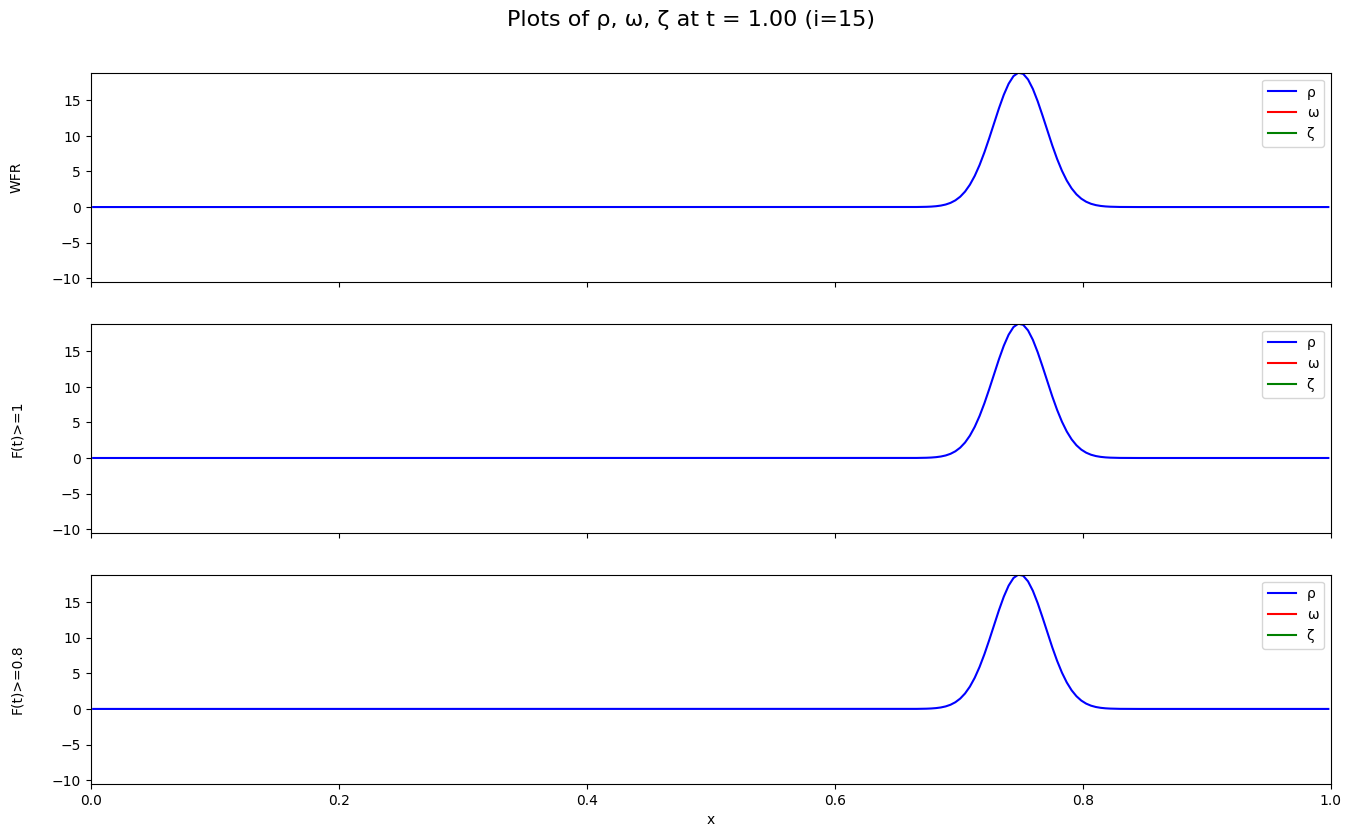

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation   # <-- new

Ds = []
vs = []
gs = []
for x in xs:
    Ds.append(x.U.D[0])
    v, g = speed_and_growth(x.V, 100)
    vs.append(v[0])
    gs.append(g)

# Time and space grids
t = np.linspace(0, 1, 16)             # t_i = i/15
x_grid = (np.arange(256) + 0.5) / 256 # x_j = (j+0.5)/256

# ------------------------------------------------------------------
# 1)  GLOBAL LIMITS (same idea you had)
# ------------------------------------------------------------------
row_labels = ["WFR", "F(t)>=1", "F(t)>=0.8"]
num_rows    = len(row_labels)

min_vals = float('inf')
max_vals = float('-inf')
for row in range(num_rows):
    row_min = min(Ds[row].min(), vs[row].min(), gs[row].min())
    row_max = max(Ds[row].max(), vs[row].max(), gs[row].max())
    min_vals = min(row_min, min_vals)
    max_vals = max(row_max, max_vals)

# ------------------------------------------------------------------
# 2)  BUILD FIGURE & STATIC ELEMENTS
# ------------------------------------------------------------------
fig, axes = plt.subplots(nrows=num_rows, ncols=1,
                         figsize=(16, 9), sharex=True)
fig.subplots_adjust(top=0.90)  # leave room for the suptitle

# Create three Line2D objects per row and store for fast access
line_sets = []          # shape: num_rows × 3
for r, ax in enumerate(axes):
    # empty lines (we'll set data in init() below)
    lρ, = ax.plot([], [], color='blue',  label='ρ')
    lω, = ax.plot([], [], color='red',   label='ω')
    lζ, = ax.plot([], [], color='green', label='ζ')
    line_sets.append((lρ, lω, lζ))

    # cosmetic stuff that never changes
    ax.set_xlim(0, 1)
    ax.set_ylim(min_vals, max_vals)
    ax.set_ylabel(row_labels[r], rotation=90, labelpad=20)
    ax.legend(loc='best')

axes[-1].set_xlabel("x")

# ------------------------------------------------------------------
# 3)  ANIMATION DRIVERS
# ------------------------------------------------------------------
def init():
    """Initialize (or clear) all lines once at the start."""
    for lρ, lω, lζ in line_sets:
        lρ.set_data([], [])
        lω.set_data([], [])
        lζ.set_data([], [])
    fig.suptitle("")    # blank title; will be updated each frame
    return [ln for triplet in line_sets for ln in triplet]

# ------------------------------------------------------------------
# 4)  CREATE & DISPLAY / SAVE THE ANIMATION
# ------------------------------------------------------------------
frames = len(t)          # keep all 16 snapshots, even if v,g are 15‑long

def update(frame_idx):
    """Plot ρ always; plot ω and ζ only if they exist for this frame."""
    for row, (lρ, lω, lζ) in enumerate(line_sets):
        # ρ exists for every frame
        lρ.set_data(x_grid, Ds[row][frame_idx, :])

        # ω, ζ might be missing for the final frame
        if frame_idx < vs[row].shape[0]:
            lω.set_data(x_grid, vs[row][frame_idx, :])
            lζ.set_data(x_grid, gs[row][frame_idx, :])
        else:                       # “ρ‑only” frame → clear the other two
            lω.set_data([], [])
            lζ.set_data([], [])

    fig.suptitle(f"Plots of ρ, ω, ζ at t = {t[frame_idx]:.2f} (i={frame_idx})",
                 fontsize=16, y=0.97)
    return [ln for triplet in line_sets for ln in triplet]

ani = animation.FuncAnimation(fig,
                              update,
                              frames=frames,
                              init_func=init,
                              blit=False,
                              repeat=False)
# Option A – display inline in a Jupyter notebook:
# from IPython.display import HTML
# HTML(ani.to_jshtml())   # interactive HTML5 video

# Option B – save to MP4 (needs ffmpeg in your PATH):
ani.save('videos/inequality_total_mass.mp4', writer='ffmpeg', dpi=200)

# Option C – save to GIF (pillow writer):
# ani.save('rho_omega_zeta.gif', writer='pillow', dpi=120)

plt.show()


# Figure 1(d)(e): 2D Population

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
import numpy as np

# Define the initial and the terminal distributions
K = 30
interval_length = [1.0, 1.0]  # 2D
grid_size = [K, K]
sigma = 0.1
np.random.seed(42)  # For reproducibility

def generate_gaussian_mixture(
    num_gaussians,
    interval_length,
    grid_size,
    dimension=2,
    means=None,          # array‑like (num_gaussians, dimension) or None
    sigmas=1.0,          # float, list/array of length num_gaussians, or None
    weights=None,        # list/array of length num_gaussians or None
    normalize_weights=True
):
    """
    Build an n‑D grid and evaluate a user‑defined (or random) Gaussian mixture on it.

    Parameters
    ----------
    num_gaussians : int
        Number of Gaussian components.
    interval_length : float or sequence of floats
        Length(s) of the interval [0, L] per dimension.
    grid_size : int or sequence of ints
        Number of grid points per dimension.
    dimension : int, default=2
        Number of spatial dimensions.
    means : array‑like or None, default=None
        Shape (num_gaussians, dimension).  When None, draws means ~ U[0,L]^d.
    sigmas : float, sequence, or None, default=1.0
        Isotropic σ (std‑dev).  Provide either
          • a single float (shared by all Gaussians)  
          • a 1‑D array/list of length num_gaussians  
        If None, defaults to 1.0.
    weights : sequence or None, default=None
        Mixing weights.  When None, draws random positive weights.
    normalize_weights : bool, default=True
        Whether to scale weights to sum to 1.  (Keeps given weights as‑is if False.)

    Returns
    -------
    grids : list[np.ndarray]
        1‑D coordinate arrays for each axis (length = grid_size[d]).
    p : np.ndarray
        The normalized mixture PDF evaluated on the n‑D grid.
    """

    # --- Hygiene: coerce scalars to lists/arrays of correct length ----------
    if isinstance(interval_length, (int, float)):
        interval_length = [interval_length] * dimension
    if isinstance(grid_size, int):
        grid_size = [grid_size] * dimension

    interval_length = np.asarray(interval_length, dtype=float)
    grid_size       = np.asarray(grid_size,       dtype=int)

    # ------------------------------------------------------------------------
    # 1. Grid construction
    # ------------------------------------------------------------------------
    grids = [
        (np.arange(g) + 0.5) / g * L
        for g, L in zip(grid_size, interval_length)
    ]
    mesh = np.meshgrid(*grids, indexing="ij")   # tuple of n coordinate arrays

    # ------------------------------------------------------------------------
    # 2. Component parameters
    # ------------------------------------------------------------------------
    # Means
    if means is None:
        means = np.random.uniform(0, interval_length, size=(num_gaussians, dimension))
    else:
        means = np.asarray(means, dtype=float)
        assert means.shape == (num_gaussians, dimension), \
            f"`means` must have shape ({num_gaussians}, {dimension})"

    # Standard deviations (isotropic so one σ per component)
    if sigmas is None:
        sigmas = 1.0
    if np.isscalar(sigmas):
        sigmas = np.full(num_gaussians, float(sigmas))
    else:
        sigmas = np.asarray(sigmas, dtype=float)
        assert sigmas.shape == (num_gaussians,), \
            f"`sigmas` must have length {num_gaussians}"

    # Weights
    if weights is None:
        weights = np.random.uniform(0, 1, size=num_gaussians)
    else:
        weights = np.asarray(weights, dtype=float)
        assert weights.shape == (num_gaussians,), \
            f"`weights` must have length {num_gaussians}"
    if normalize_weights:
        weights = weights / np.sum(weights)

    # ------------------------------------------------------------------------
    # 3. Evaluate mixture
    # ------------------------------------------------------------------------
    p = np.zeros(mesh[0].shape, dtype=float)
    for k in range(num_gaussians):
        # Squared Euclidean distance ‖x - μ_k‖²
        sqdist = sum((mesh[d] - means[k, d])**2 for d in range(dimension))
        gaussian_k = np.exp(-0.5 * sqdist / sigmas[k]**2)
        p += weights[k] * gaussian_k

    # Ensure p is a valid PDF on the discrete grid
    p /= np.sum(p)

    return grids, p
# One component exactly at the centre (0.5, 0.5)
means_case1   = [[0.5, 0.5]]
sigmas_case1  = sigma   # could also pass [sigma_common]
weights_case1 = [1.0]          # only one component

grids, rho_0 = generate_gaussian_mixture(
    num_gaussians=1,
    interval_length=interval_length,
    grid_size=grid_size,
    dimension=2,
    means=means_case1,
    sigmas=sigmas_case1,
    weights=weights_case1
)

means_case2   = [
    [0.25, 0.25],   # bottom‑left
    [0.75, 0.75],   # top‑right
]

sigmas_case2  = [0.15, 0.05]   # big spread vs small spread
# –OR– set sigmas_case2 = sigma_common and play with weights instead

weights_case2 = [0.5, 0.5]     # equal mass (change if desired)

_, rho_1 = generate_gaussian_mixture(
    num_gaussians=2,
    interval_length=interval_length,
    grid_size=grid_size,
    dimension=2,
    means=means_case2,
    sigmas=sigmas_case2,
    weights=weights_case2
)

# Scale it so that they are DENSITIES, not probabilities
rho_0 = rho_0 * K * K
rho_1 = rho_1 * K * K

# Create meshgrid for plotting
X, Y = grids

T=15
xs = []
delta = 1.0
z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0, 1.0), niter = 1000, delta=delta)
D = z.U.D[0]
xs.append(z)

# Calculate the constrained geodesic
t = np.linspace(0, 1, T)  # t_i = i / T
F = 3 - 8 * (t - 0.5) ** 2 

z, lists = computeGeodesic(rho_0, rho_1, T, (1.0, 1.0, 1.0), np.ones((T, K, K)), F, niter = 1000, delta=delta)
xs.append(z)

C:\Users\mao17\AppData\Local\Temp\ipykernel_43732\453738031.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 1])   # still leave room for colourbar


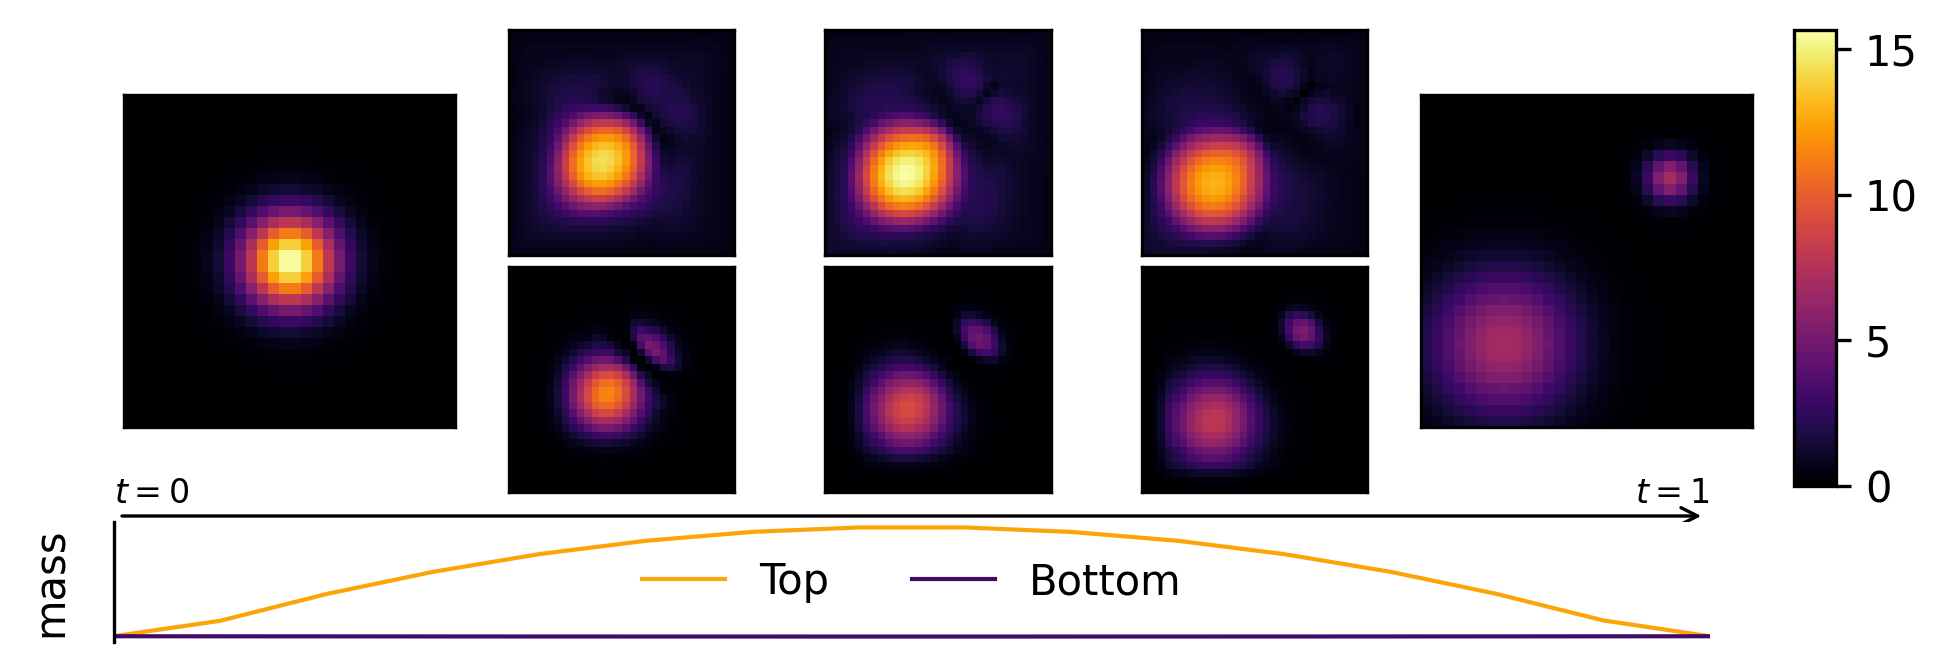

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib import colors                     # <- new
from matplotlib.patches import FancyArrowPatch
from matplotlib.cm import inferno


# --------------------------------------------------------------------
# choose snapshots (same as before)
# --------------------------------------------------------------------
T = z.U.D[0].shape[0]
t_samples = np.array([0.25, 0.50, 0.75])
idx = (t_samples * (T - 1)).round().astype(int)

# --------------------------------------------------------------------
# ----- 1. gather every array that will be shown ---------------------
# --------------------------------------------------------------------
all_arrays = [rho_0, rho_1]                      # boundary densities
all_arrays += list(z.U.D[0][idx])                # c‑row snapshots
all_arrays += list(D[idx])                       # p‑row snapshots

vmin = min(a.min() for a in all_arrays)
vmax = max(a.max() for a in all_arrays)
norm = colors.Normalize(vmin=vmin, vmax=vmax)    # shared scale

# --------------------------------------------------------------------
# layout: identical to before
# --------------------------------------------------------------------
fig = plt.figure(figsize=(7, 2), dpi=300)
gs  = gridspec.GridSpec(nrows=2, ncols=5,
                        width_ratios=[1.1, 1, 1, 1, 1.1],
                        wspace=0.05, hspace=0.05)

ax_rho0 = fig.add_subplot(gs[:, 0])
ax_rho1 = fig.add_subplot(gs[:, 4])
ax_c    = [fig.add_subplot(gs[0, j]) for j in range(1, 4)]
ax_p    = [fig.add_subplot(gs[1, j]) for j in range(1, 4)]

# --------------------------------------------------------------------
# helper now takes the shared norm
# --------------------------------------------------------------------
def imshow_density(ax, data, *, norm, cmap="inferno"):
    ax.imshow(data, origin="lower", cmap=cmap,
              extent=(0, 1, 0, 1), interpolation='nearest',
              norm=norm)
    ax.set_xticks([]); ax.set_yticks([])

# --------------------------------------------------------------------
# plot all panels
# --------------------------------------------------------------------
imshow_density(ax_rho0, rho_0, norm=norm)
imshow_density(ax_rho1, rho_1, norm=norm)

for k, ax in enumerate(ax_c):
    imshow_density(ax, z.U.D[0][idx[k]], norm=norm)

for k, ax in enumerate(ax_p):
    imshow_density(ax, D[idx[k]], norm=norm)

# --------------------------------------------------------------------
# optional: add one slim colorbar under the figure
# --------------------------------------------------------------------

cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.76])   # [left,bottom,width,height]
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="inferno"),
             cax=cbar_ax)

# --------------------------------------------------------------------
# 2.  slim mass‑vs‑time track  ───────────────────────────────────────
# --------------------------------------------------------------------
# place it *above* the arrow; tweak the numbers if it overlaps anything
# (0.12, 0.14, 0.76, 0.06) = [left, bottom, width, height] in fig‑coords
mass_ax = fig.add_axes([0.12, -0.14, 0.76, 0.2], zorder=2)
cell_area = 1 / (K * K)  # area of one cell in the grid

times   = np.linspace(0, 1, T)    # t‑coordinate of every stored slice
mass_c  = z.U.D[0].sum(axis=(1, 2)) * cell_area   # “top row” trajectory
mass_p  =        D.sum(axis=(1, 2)) * cell_area   # “bottom row” trajectory

mass_ax.plot(times, mass_c,  lw=1.0, color=inferno(0.8), label="Top")
mass_ax.plot(times, mass_p,  lw=1.0, color=inferno(0.2), label="Bottom")

# cosmetics: no frame, no x‑ticks (arrow already shows t), tiny y‑label
mass_ax.set_xlim(0, 1)
mass_ax.set_xticks([])                       # x‑ticks clash with arrow
mass_ax.set_yticks([])
mass_ax.spines[['top', 'right', 'bottom']].set_visible(False)
mass_ax.set_ylabel(r"mass", rotation=90, labelpad=10, fontsize=10)

mass_ax.legend(frameon=False, fontsize=10, ncol=2, loc="center")

# --------------------------------------------------------------------
# bottom time arrow (unchanged)
# --------------------------------------------------------------------
arrow_ax = fig.add_axes([0.12, 0.02, 0.76, 0.10], zorder=-1)
arrow_ax.axis("off")
arrow_ax.annotate("", xy=(1, 0.5), xytext=(0, 0.5),
                  xycoords="axes fraction",
                  arrowprops=dict(arrowstyle="->", lw=0.8))
arrow_ax.text(0, 0.6, r"$t=0$", ha="left",  va="bottom", fontsize=8)
arrow_ax.text(1, 0.6, r"$t=1$", ha="right", va="bottom", fontsize=8)

# --------------------------------------------------------------------
# save without extra titles / row labels
# --------------------------------------------------------------------
plt.tight_layout(rect=[0, 0.05, 0.9, 1])   # still leave room for colourbar
plt.savefig("figures/geodesic_compare_with_mass.png",
            bbox_inches="tight", dpi=300)
plt.show()
plt.close(fig)

In [116]:
# --------------------------------------------------------------
#  Exact‑pixel “total mass vs t” figure: 2211 px × 408 px       |
# --------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import inferno

# -------- data -------------------------------------------------
Ds          = [x.U.D[0] for x in xs]                # three solutions
mass_curves = [np.sum(D, axis=(1, 2)) / (30 * 30) for D in Ds] # total mass vs t
t           = np.linspace(0, 1, Ds[0].shape[0])     # 16 points


# -------- figure geometry for 2211 × 408 px at 600 dpi --------
dpi_out          = 600
fig_width_inch   = 2211 / dpi_out -0.09           # ≈ 3.685"
fig_height_inch  =  528 / dpi_out -0.124          # ≈ 0.680"

rcParams.update({"font.size": 10, "text.usetex": False})
colours = [inferno(0.3), inferno(0.8)]

fig = plt.figure(figsize=(fig_width_inch, fig_height_inch), dpi=dpi_out,
                 facecolor="white")
ax  = fig.add_axes([0.03, 0.04, 0.94, 0.93])  # fill almost everything

# -------- plot -------------------------------------------------
for m, c in zip(mass_curves, colours):
    ax.plot(t, m, marker='o', ms=2, lw=0.9, color=c)

ax.axhline(1.0, color="0.4", lw=0.6, ls="--", zorder=0)
ax.axhline(3.0, color="0.4", lw=0.6, ls=":",  zorder=0)

# -------- axes cosmetics --------------------------------------
ax.set_xlim(0, 1);  ax.set_ylim(0.8, 3.23)
ax.set_xticks([0, 0.5, 1]); ax.set_xticklabels(["0", "0.5", "1"])
ax.set_yticks([1.0, 3.0]);  ax.set_yticklabels(["1.0", "3.0"])
ax.tick_params(axis="both", direction="out", length=2, pad=1)
for s in ("right", "top"): ax.spines[s].set_visible(False)

# -------- tiny “t” label just left of the x‑axis origin -------
ax.text(-0.03, -0.08, r"$t$", transform=ax.transAxes,
        ha="right", va="top", fontsize=9)


# -------- save -----------------------------------------------
fig.savefig("figures/total_mass_camera_ready_2d.png",
            dpi=dpi_out, bbox_inches="tight", pad_inches=0, transparent=True)
plt.close(fig)
print("✓ Saved figures/total_mass_camera_ready_2d.png (2211 × 408 px)")


✓ Saved figures/total_mass_camera_ready_2d.png (2211 × 408 px)
